In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

In [2]:

def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.2)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [3]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [4]:
def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights=None
    )
    modelInput.load_weights("D:/MultiCancer/weights_mobilenet_v3_small_224_1.0_float_no_top.h5",by_name='true',skip_mismatch='true')
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [5]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'MobileNet.h5', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint


In [6]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [7]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [8]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    
def saveModel(model, className):
    model.save(className + " - MobileNetV3.h5")
    print("Model Saved!")

In [9]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [10]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [11]:
mpath = "D:/Multi Cancer"
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 20
lr = 0.001

for i in classPaths:
    className = i
    print(className)
    

Brain Cancer
Breast Cancer
Cervical Cancer
Kidney Cancer
Lung and Colon Cancer
Lymphoma
Oral Cancer



Total :  Found 15241 files belonging to 4 classes.

For Training :  Found 12193 images belonging to 4 classes.

For Val :  Found 3048 images belonging to 4 classes.

No of Classes :  4
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor', 'none']
Image Shape :  (32, 256, 256, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_1[0][0]']         
       

c:\Users\shiva\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


382/382 [==============================] - 321s 830ms/step - loss: 0.7292 - accuracy: 0.8911 - val_loss: 0.3890 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 2/20
382/382 [==============================] - ETA: 0s - loss: 0.2393 - accuracy: 0.9615
Epoch 2: val_loss did not improve from 0.38896
382/382 [==============================] - 152s 398ms/step - loss: 0.2393 - accuracy: 0.9615 - val_loss: 0.4066 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 3/20
382/382 [==============================] - ETA: 0s - loss: 0.1199 - accuracy: 0.9812
Epoch 3: val_loss improved from 0.38896 to 0.38193, saving model to Oral CancerMobileNet.h5
382/382 [==============================] - 150s 393ms/step - loss: 0.1199 - accuracy: 0.9812 - val_loss: 0.3819 - val_accuracy: 0.9518 - lr: 0.0010
Epoch 4/20
382/382 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9809
Epoch 4: val_loss improved from 0.38193 to 0.33060, saving model to Oral CancerMobileNet.h5
382/382 [============================

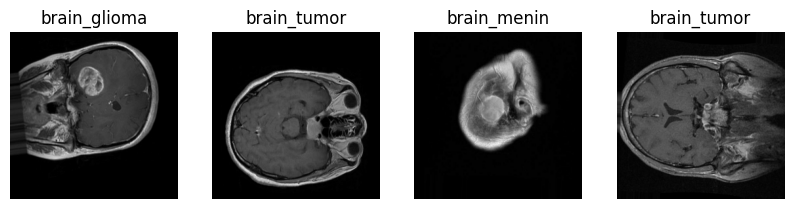

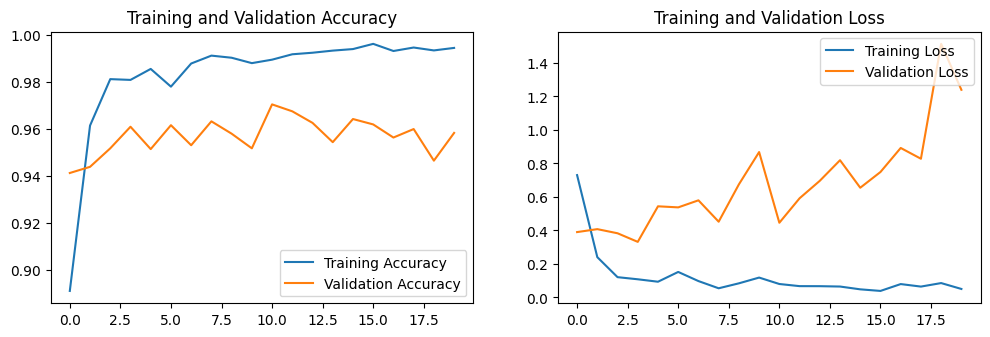

96/96 [==============================] - 32s 332ms/step - loss: 1.2385 - accuracy: 0.9583
Accuracy on the Test Set = 95.83 %
Model Saved!
True :  [0 0 0 ... 3 3 3]
96/96 [==============================] - 35s 342ms/step
Predicted :  [0 0 0 ... 3 3 3]


<Figure size 640x480 with 0 Axes>

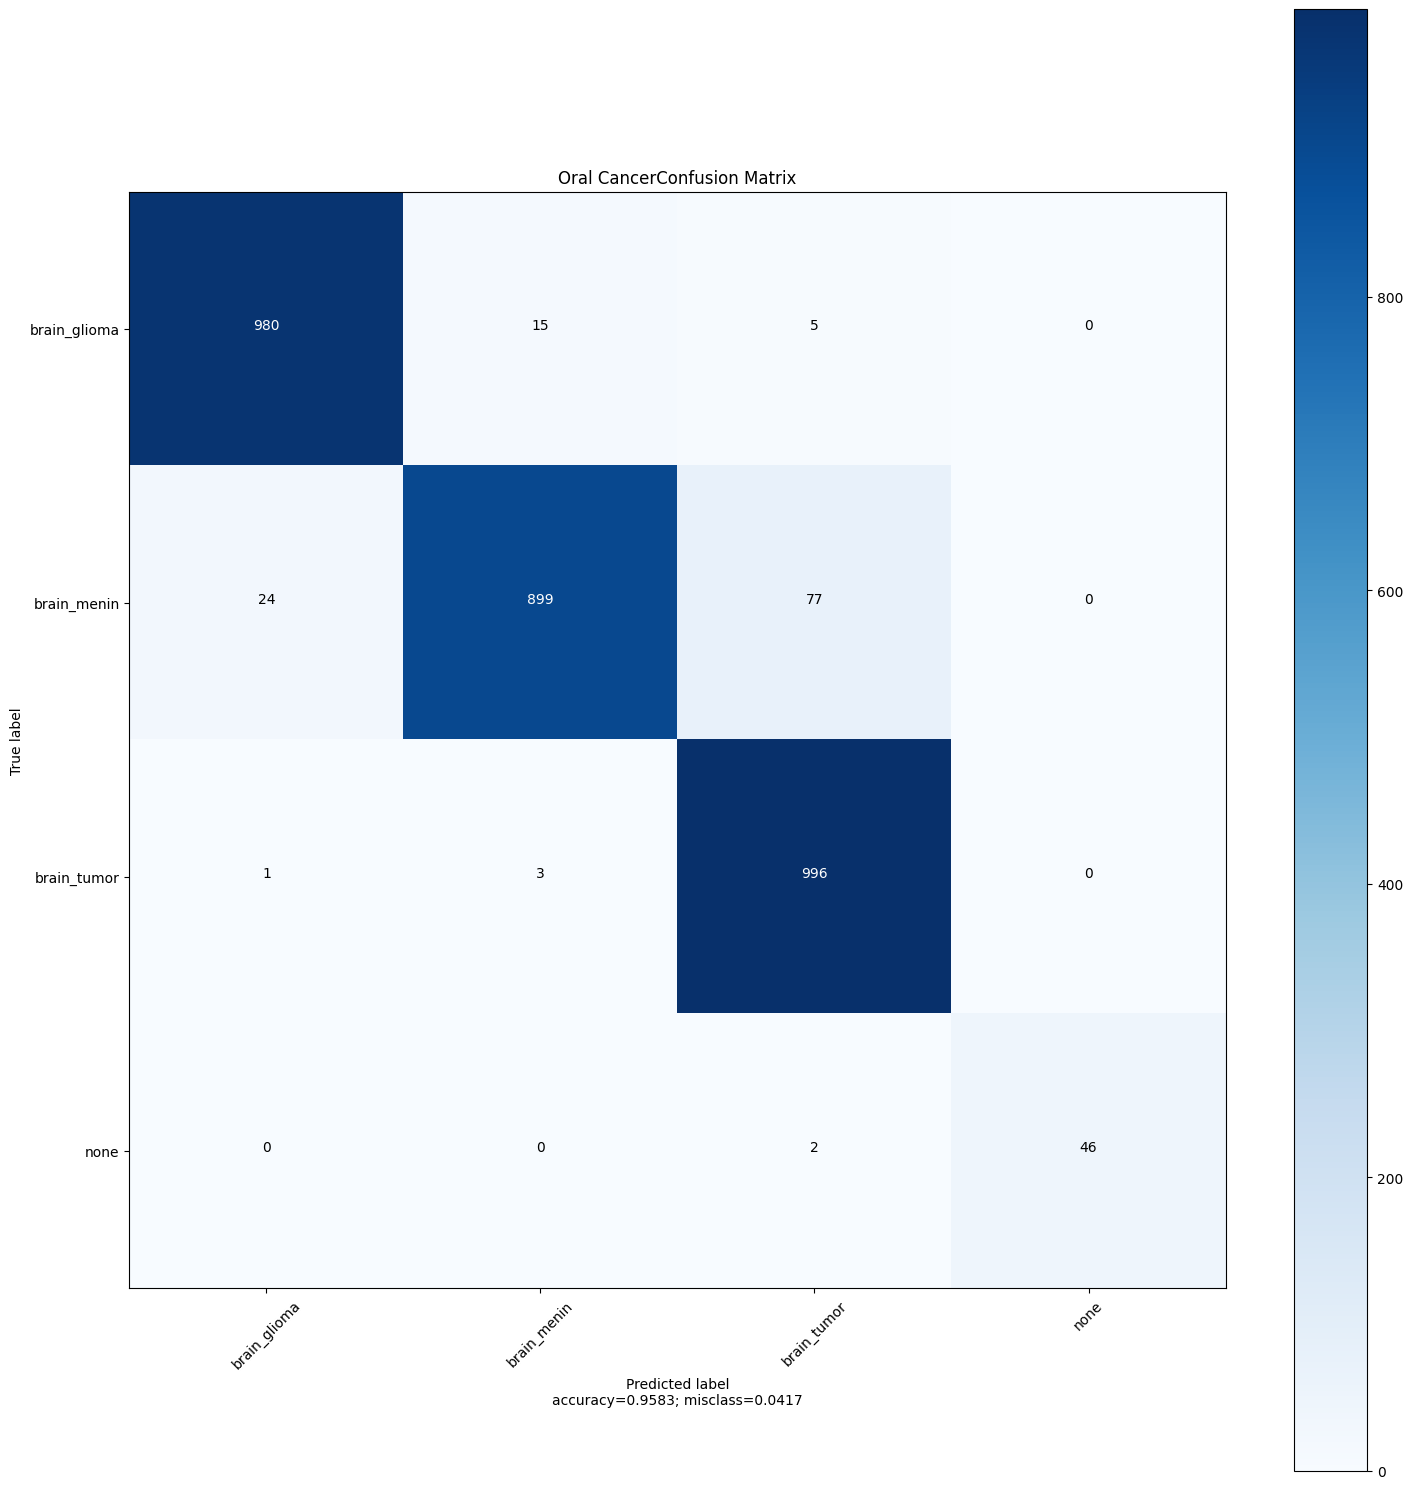

<Figure size 640x480 with 0 Axes>

In [14]:
cpath = os.path.join(mpath, 'Brain Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10250 files belonging to 3 classes.

For Training :  Found 8201 images belonging to 3 classes.

For Val :  Found 2049 images belonging to 3 classes.

No of Classes :  3
Classes :  ['breast_benign', 'breast_malignant', 'none']
Image Shape :  (32, 256, 256, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                 

c:\Users\shiva\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


257/257 [==============================] - 241s 924ms/step - loss: 0.2628 - accuracy: 0.9623 - val_loss: 0.3859 - val_accuracy: 0.9419 - lr: 0.0010
Epoch 2/20
257/257 [==============================] - ETA: 0s - loss: 0.0426 - accuracy: 0.9927
Epoch 2: val_loss improved from 0.38592 to 0.21849, saving model to Oral CancerMobileNet.h5
257/257 [==============================] - 117s 455ms/step - loss: 0.0426 - accuracy: 0.9927 - val_loss: 0.2185 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 3/20
257/257 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9974
Epoch 3: val_loss did not improve from 0.21849
257/257 [==============================] - 113s 439ms/step - loss: 0.0115 - accuracy: 0.9974 - val_loss: 0.2190 - val_accuracy: 0.9776 - lr: 0.0010
Epoch 4/20
257/257 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9973
Epoch 4: val_loss improved from 0.21849 to 0.19664, saving model to Oral CancerMobileNet.h5
257/257 [============================

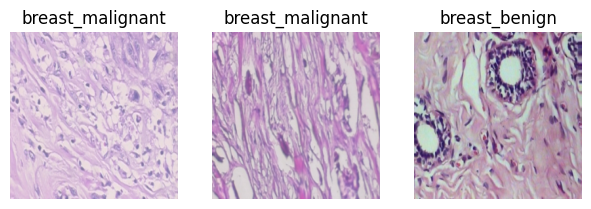

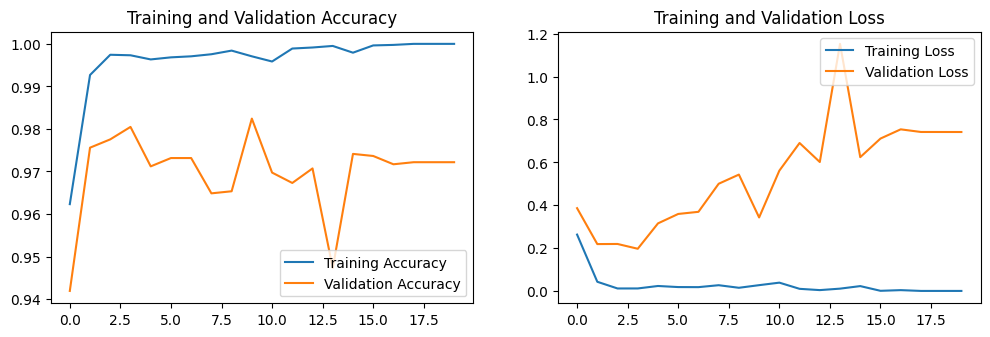

65/65 [==============================] - 26s 400ms/step - loss: 0.7412 - accuracy: 0.9722
Accuracy on the Test Set = 97.22 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
65/65 [==============================] - 27s 379ms/step
Predicted :  [0 0 0 ... 2 0 0]


<Figure size 640x480 with 0 Axes>

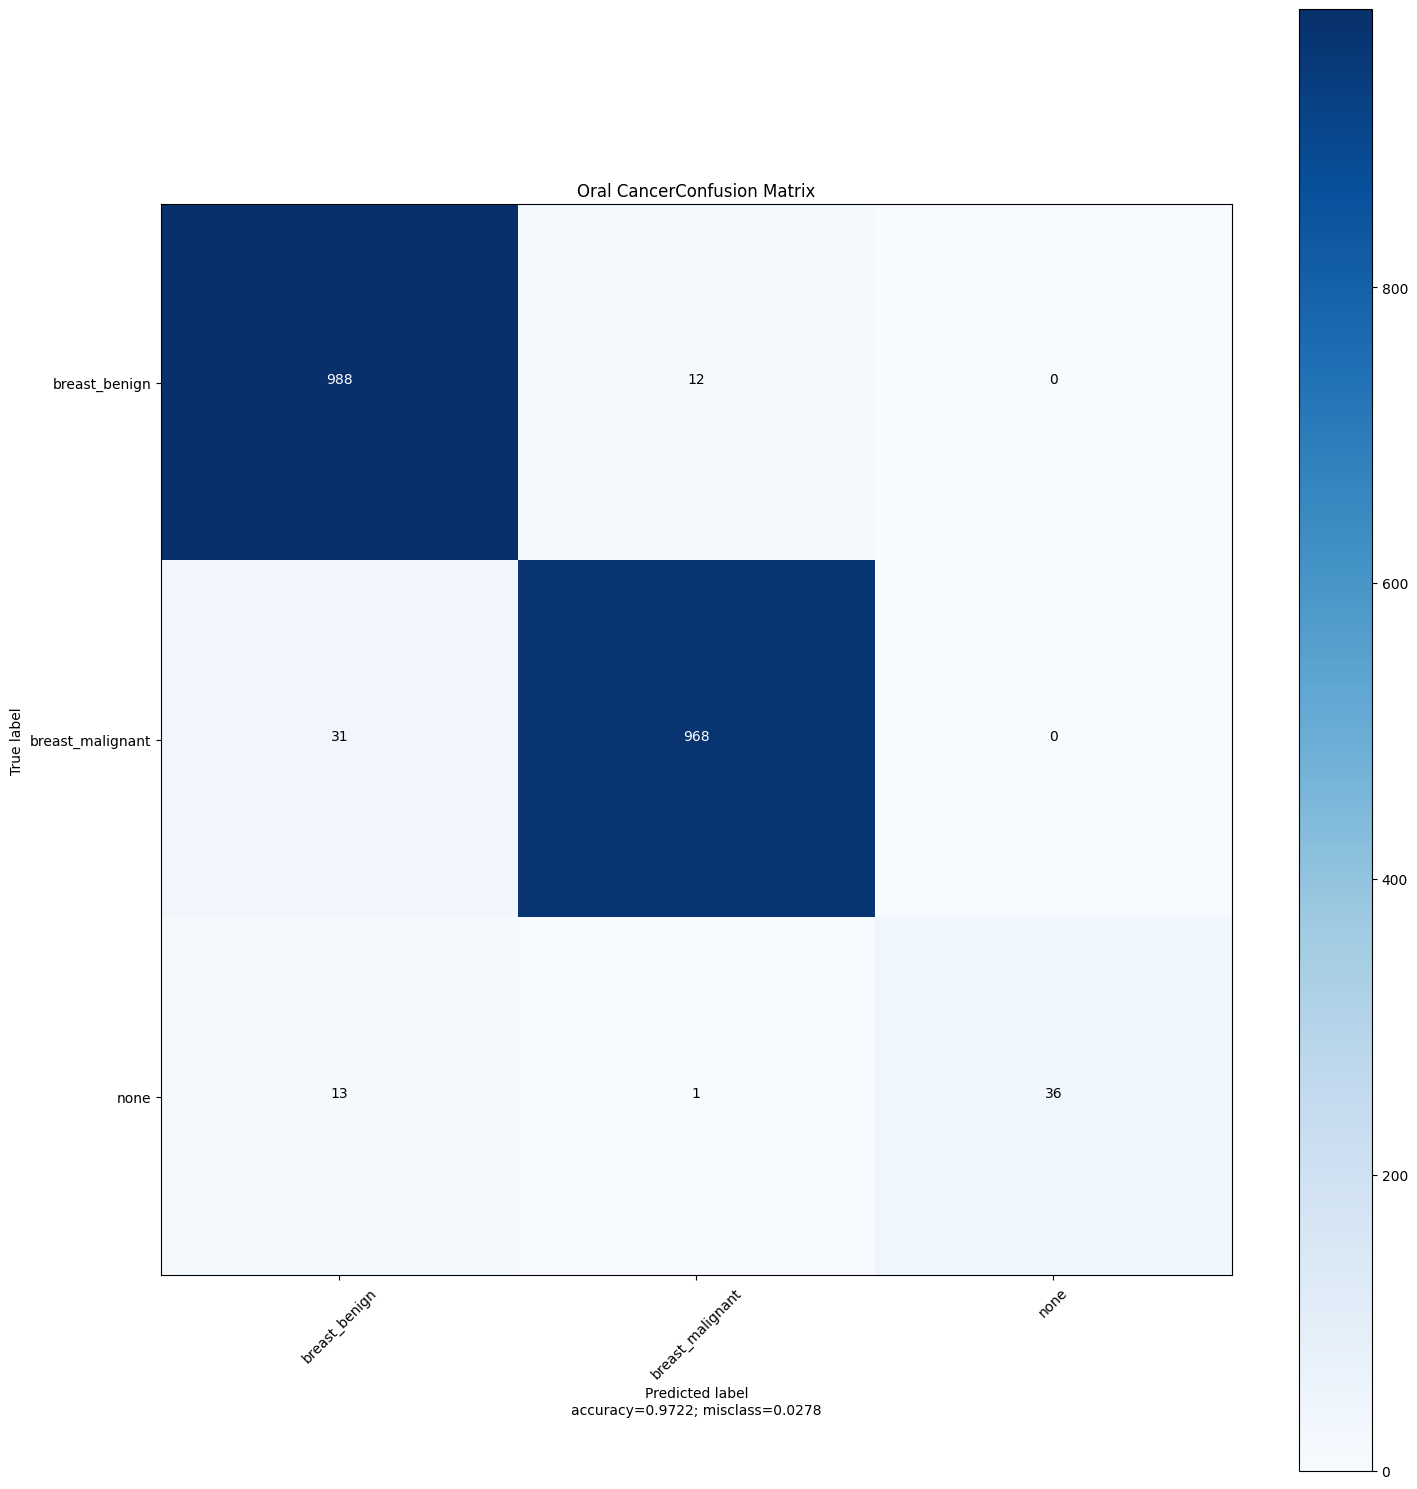

<Figure size 640x480 with 0 Axes>

In [13]:
cpath = os.path.join(mpath, 'Breast Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 25221 files belonging to 6 classes.

For Training :  Found 20177 images belonging to 6 classes.

For Val :  Found 5044 images belonging to 6 classes.

No of Classes :  6
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi', 'none']
Image Shape :  (32, 256, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_

c:\Users\shiva\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


631/631 [==============================] - 746s 1s/step - loss: 0.5187 - accuracy: 0.9130 - val_loss: 0.1497 - val_accuracy: 0.9740 - lr: 0.0010
Epoch 2/20
631/631 [==============================] - ETA: 0s - loss: 0.0787 - accuracy: 0.9859
Epoch 2: val_loss did not improve from 0.14969
631/631 [==============================] - 715s 1s/step - loss: 0.0787 - accuracy: 0.9859 - val_loss: 0.2891 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 3/20
631/631 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.9808
Epoch 3: val_loss did not improve from 0.14969
631/631 [==============================] - 396s 628ms/step - loss: 0.1366 - accuracy: 0.9808 - val_loss: 0.2163 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 4/20
631/631 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9890
Epoch 4: val_loss did not improve from 0.14969
631/631 [==============================] - 236s 374ms/step - loss: 0.0856 - accuracy: 0.9890 - val_loss: 0.2015 - val_accuracy: 0.979

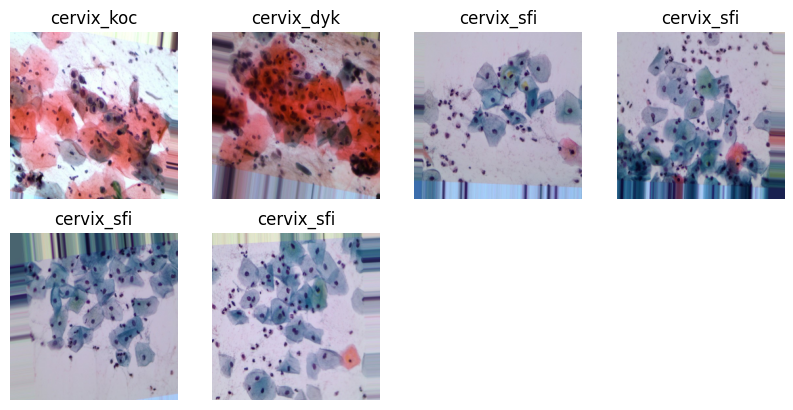

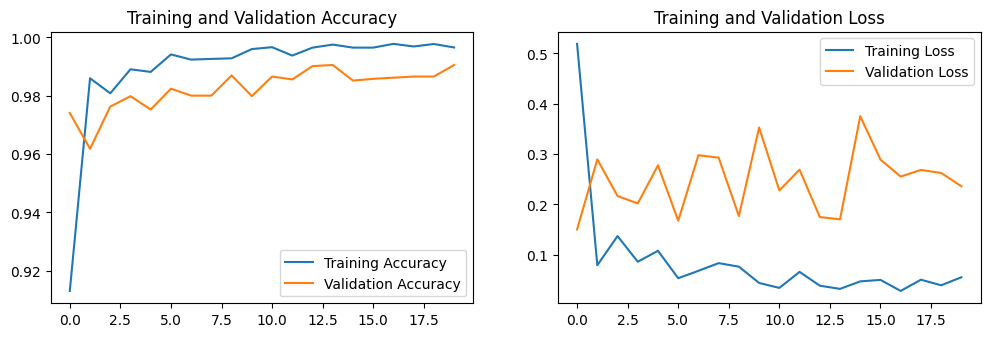

158/158 [==============================] - 45s 283ms/step - loss: 0.2357 - accuracy: 0.9905
Accuracy on the Test Set = 99.05 %
Model Saved!
True :  [0 0 0 ... 5 5 5]
158/158 [==============================] - 45s 281ms/step
Predicted :  [0 0 0 ... 5 5 5]


<Figure size 640x480 with 0 Axes>

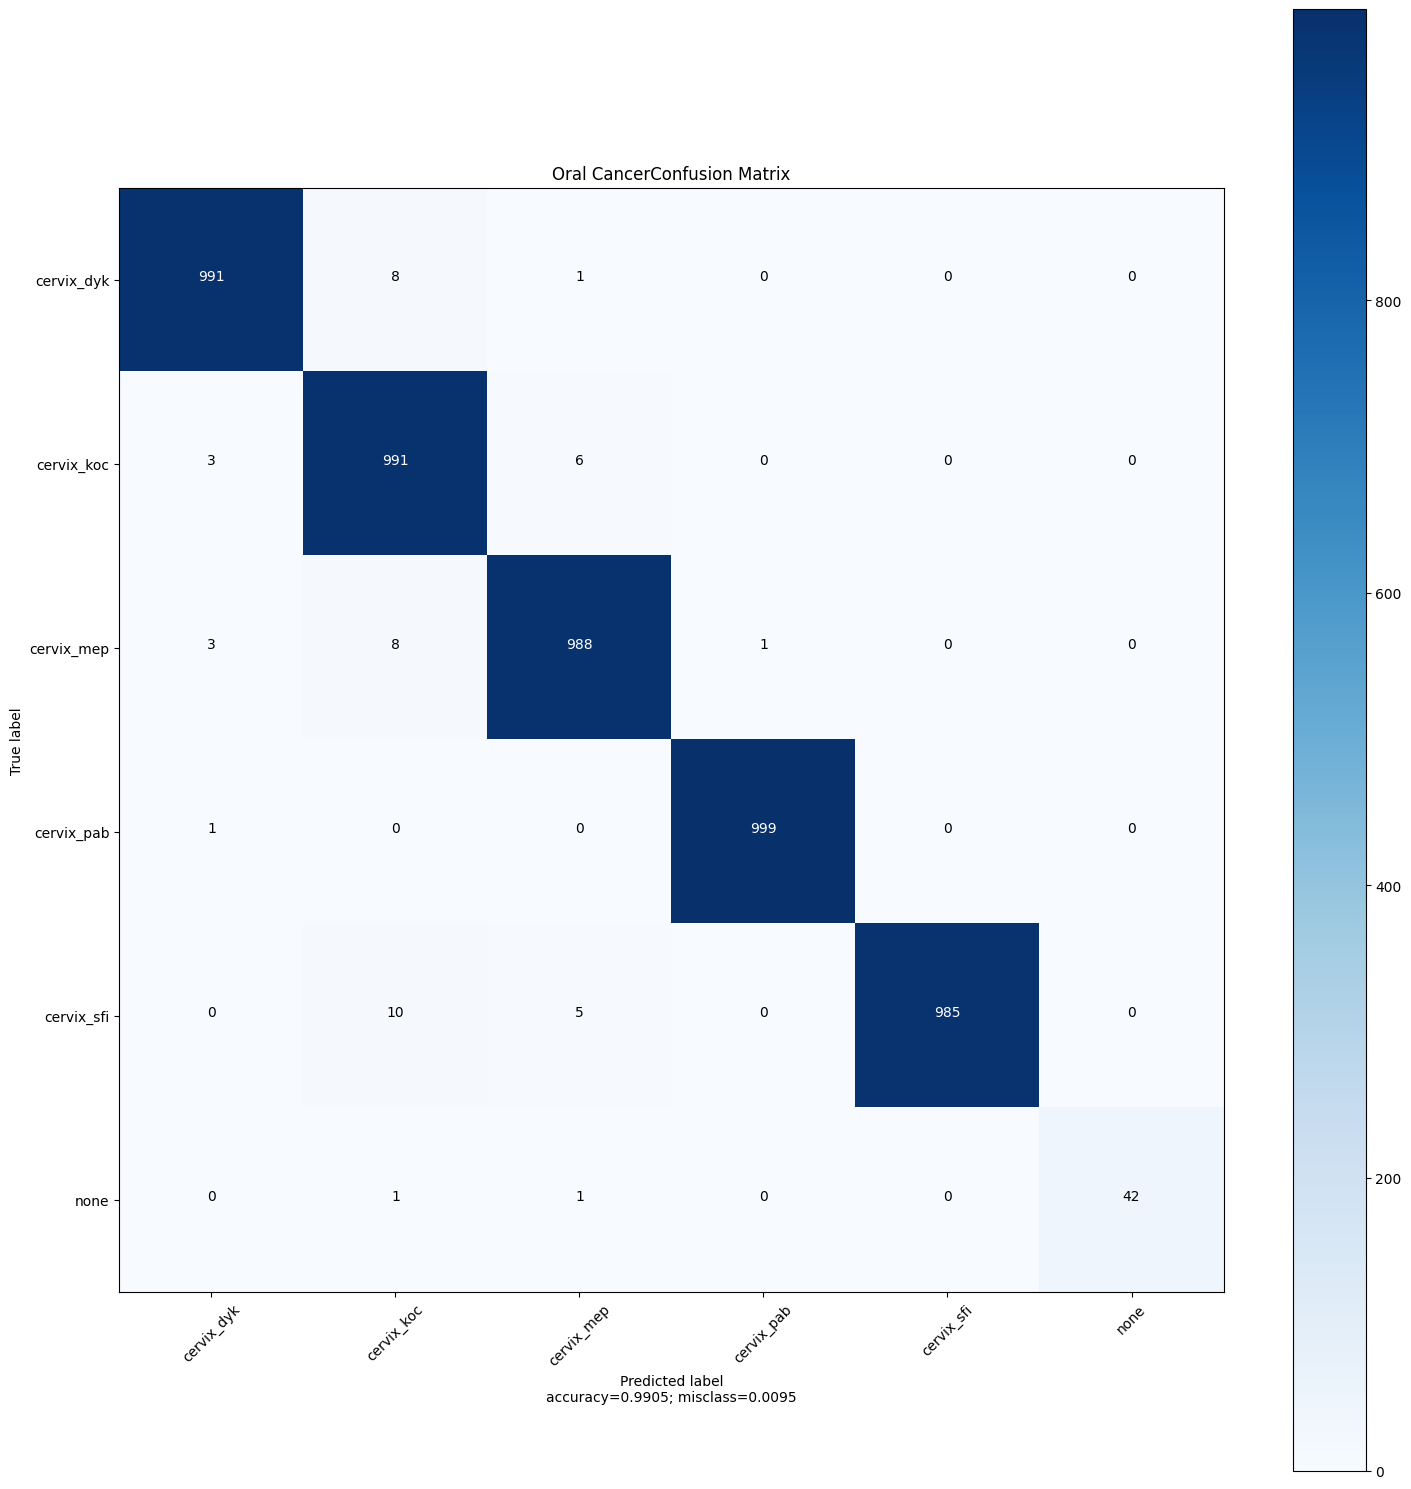

<Figure size 640x480 with 0 Axes>

In [14]:
cpath = os.path.join(mpath, 'Cervical Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10251 files belonging to 3 classes.

For Training :  Found 8201 images belonging to 3 classes.

For Val :  Found 2050 images belonging to 3 classes.

No of Classes :  3
Classes :  ['kidney_normal', 'kidney_tumor', 'none']
Image Shape :  (32, 256, 256, 3)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_2[0][0]']         
                   

c:\Users\shiva\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


257/257 [==============================] - 243s 931ms/step - loss: 0.1678 - accuracy: 0.9771 - val_loss: 0.8844 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 2/20
257/257 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 0.9985
Epoch 2: val_loss did not improve from 0.88437
257/257 [==============================] - 125s 488ms/step - loss: 0.0077 - accuracy: 0.9985 - val_loss: 1.6092 - val_accuracy: 0.8263 - lr: 0.0010
Epoch 3/20
257/257 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9998
Epoch 3: val_loss improved from 0.88437 to 0.72156, saving model to Oral CancerMobileNet.h5
257/257 [==============================] - 147s 571ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.7216 - val_accuracy: 0.9459 - lr: 0.0010
Epoch 4/20
257/257 [==============================] - ETA: 0s - loss: 7.8218e-06 - accuracy: 1.0000
Epoch 4: val_loss did not improve from 0.72156
257/257 [==============================] - 148s 576ms/step - loss: 7.8218e-06 

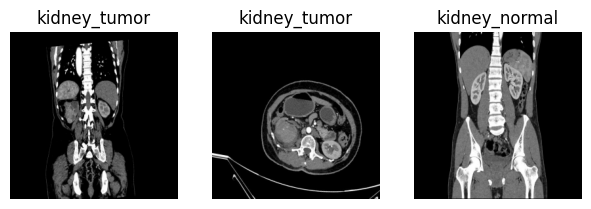

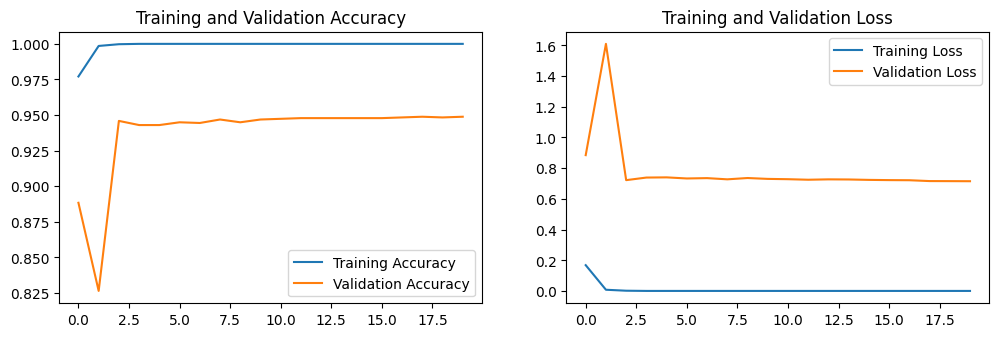

65/65 [==============================] - 22s 335ms/step - loss: 0.7145 - accuracy: 0.9488
Accuracy on the Test Set = 94.88 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
65/65 [==============================] - 20s 290ms/step
Predicted :  [0 0 0 ... 2 2 2]


<Figure size 640x480 with 0 Axes>

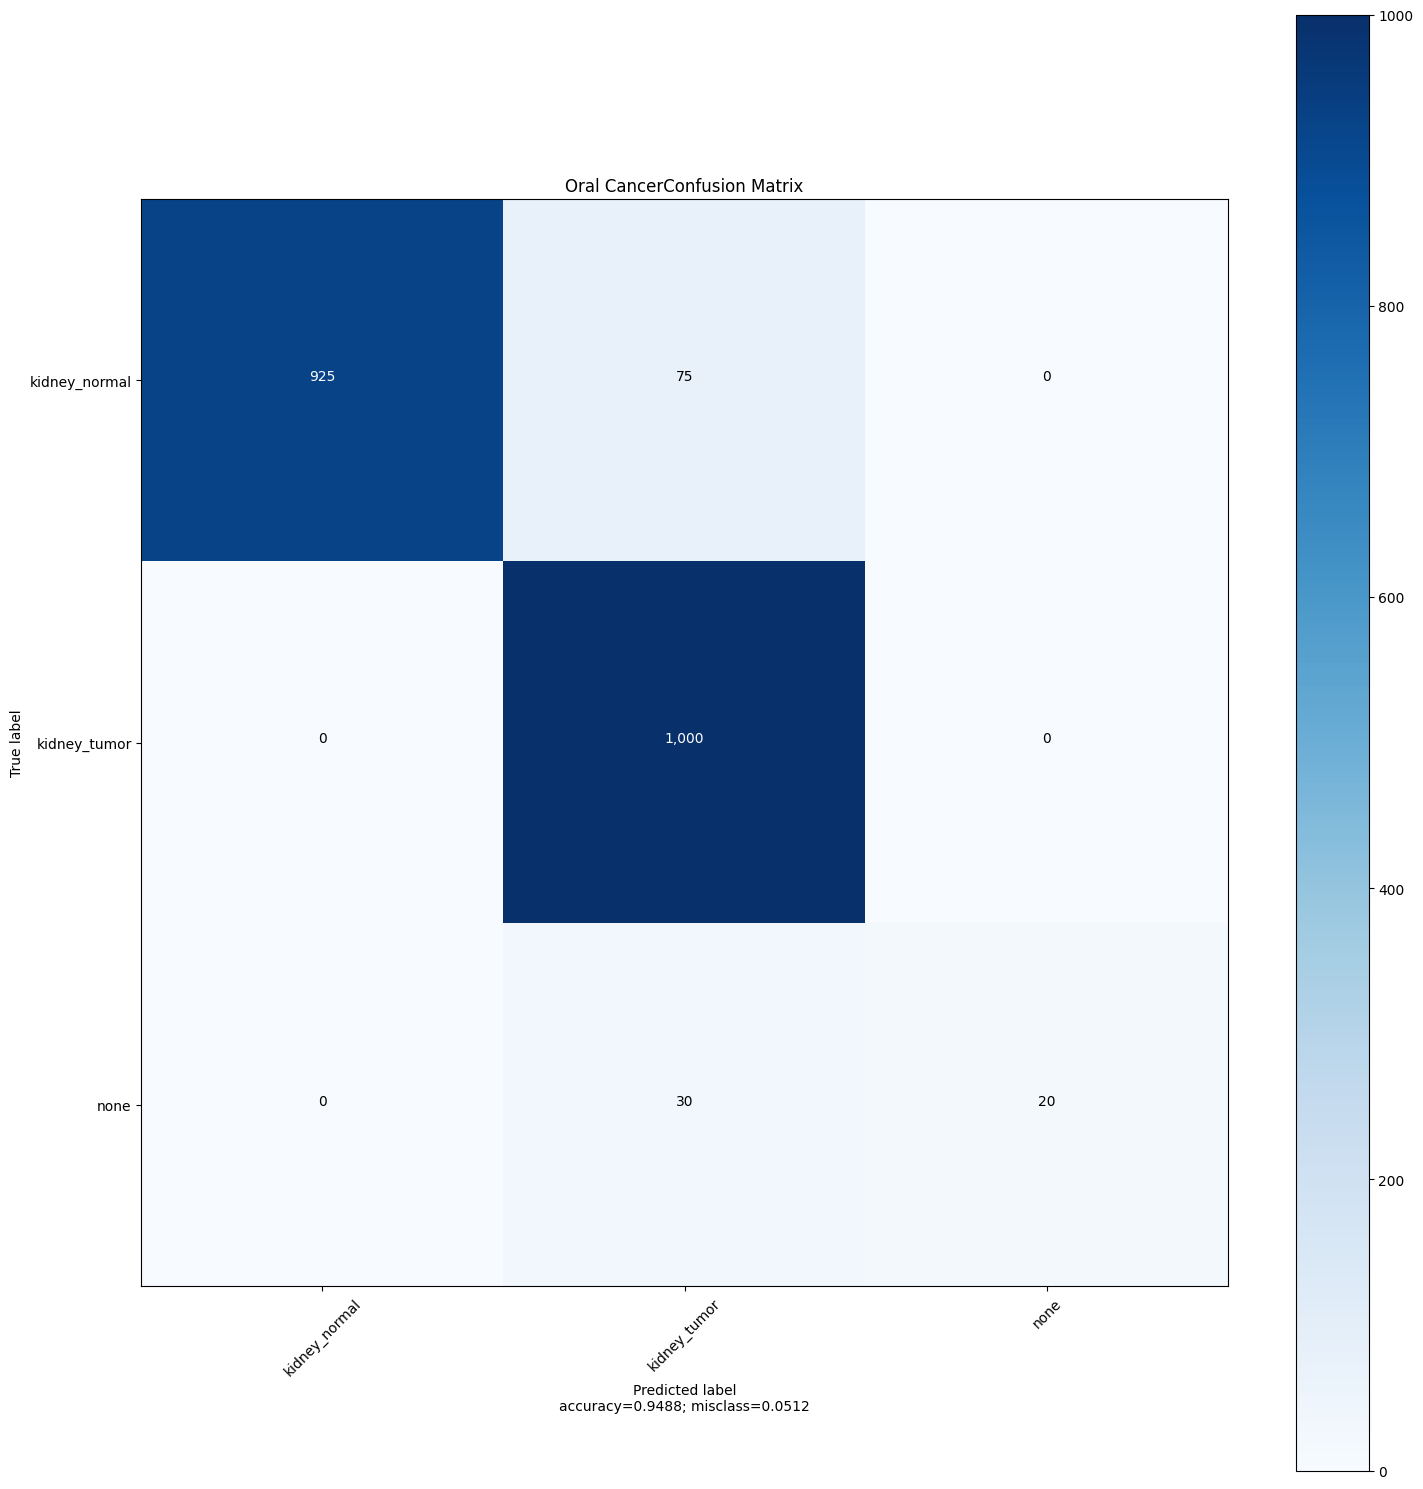

<Figure size 640x480 with 0 Axes>

In [15]:
cpath = os.path.join(mpath, 'Kidney Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 25221 files belonging to 6 classes.

For Training :  Found 20177 images belonging to 6 classes.

For Val :  Found 5044 images belonging to 6 classes.

No of Classes :  6
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc', 'none']
Image Shape :  (32, 256, 256, 3)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_3[0][0]'

c:\Users\shiva\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


631/631 [==============================] - 634s 1s/step - loss: 0.2721 - accuracy: 0.9490 - val_loss: 0.1435 - val_accuracy: 0.9770 - lr: 0.0010
Epoch 2/20
631/631 [==============================] - ETA: 0s - loss: 0.0982 - accuracy: 0.9835
Epoch 2: val_loss did not improve from 0.14350
631/631 [==============================] - 437s 692ms/step - loss: 0.0982 - accuracy: 0.9835 - val_loss: 0.2717 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 3/20
631/631 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9931
Epoch 3: val_loss did not improve from 0.14350
631/631 [==============================] - 271s 429ms/step - loss: 0.0401 - accuracy: 0.9931 - val_loss: 0.1852 - val_accuracy: 0.9804 - lr: 0.0010
Epoch 4/20
631/631 [==============================] - ETA: 0s - loss: 0.0395 - accuracy: 0.9942
Epoch 4: val_loss did not improve from 0.14350
631/631 [==============================] - 254s 402ms/step - loss: 0.0395 - accuracy: 0.9942 - val_loss: 0.1600 - val_accuracy: 0.

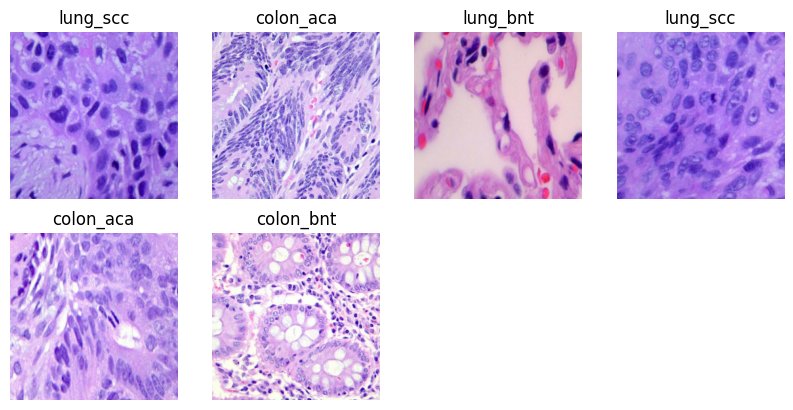

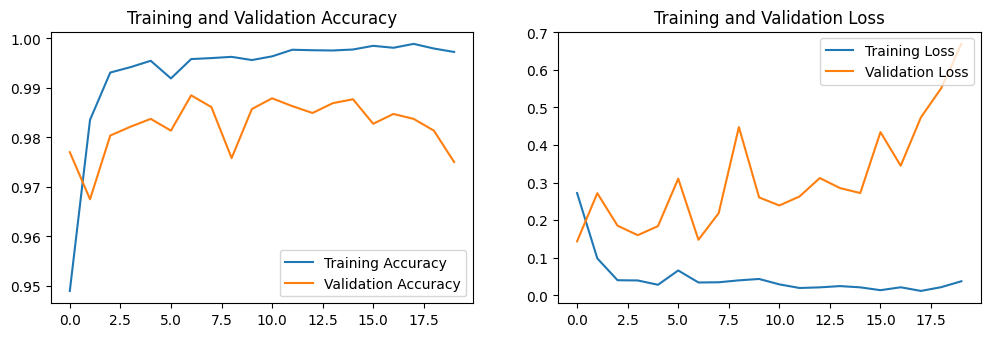

158/158 [==============================] - 46s 291ms/step - loss: 0.6690 - accuracy: 0.9750
Accuracy on the Test Set = 97.50 %
Model Saved!
True :  [0 0 0 ... 5 5 5]
158/158 [==============================] - 51s 313ms/step
Predicted :  [0 0 0 ... 1 4 5]


<Figure size 640x480 with 0 Axes>

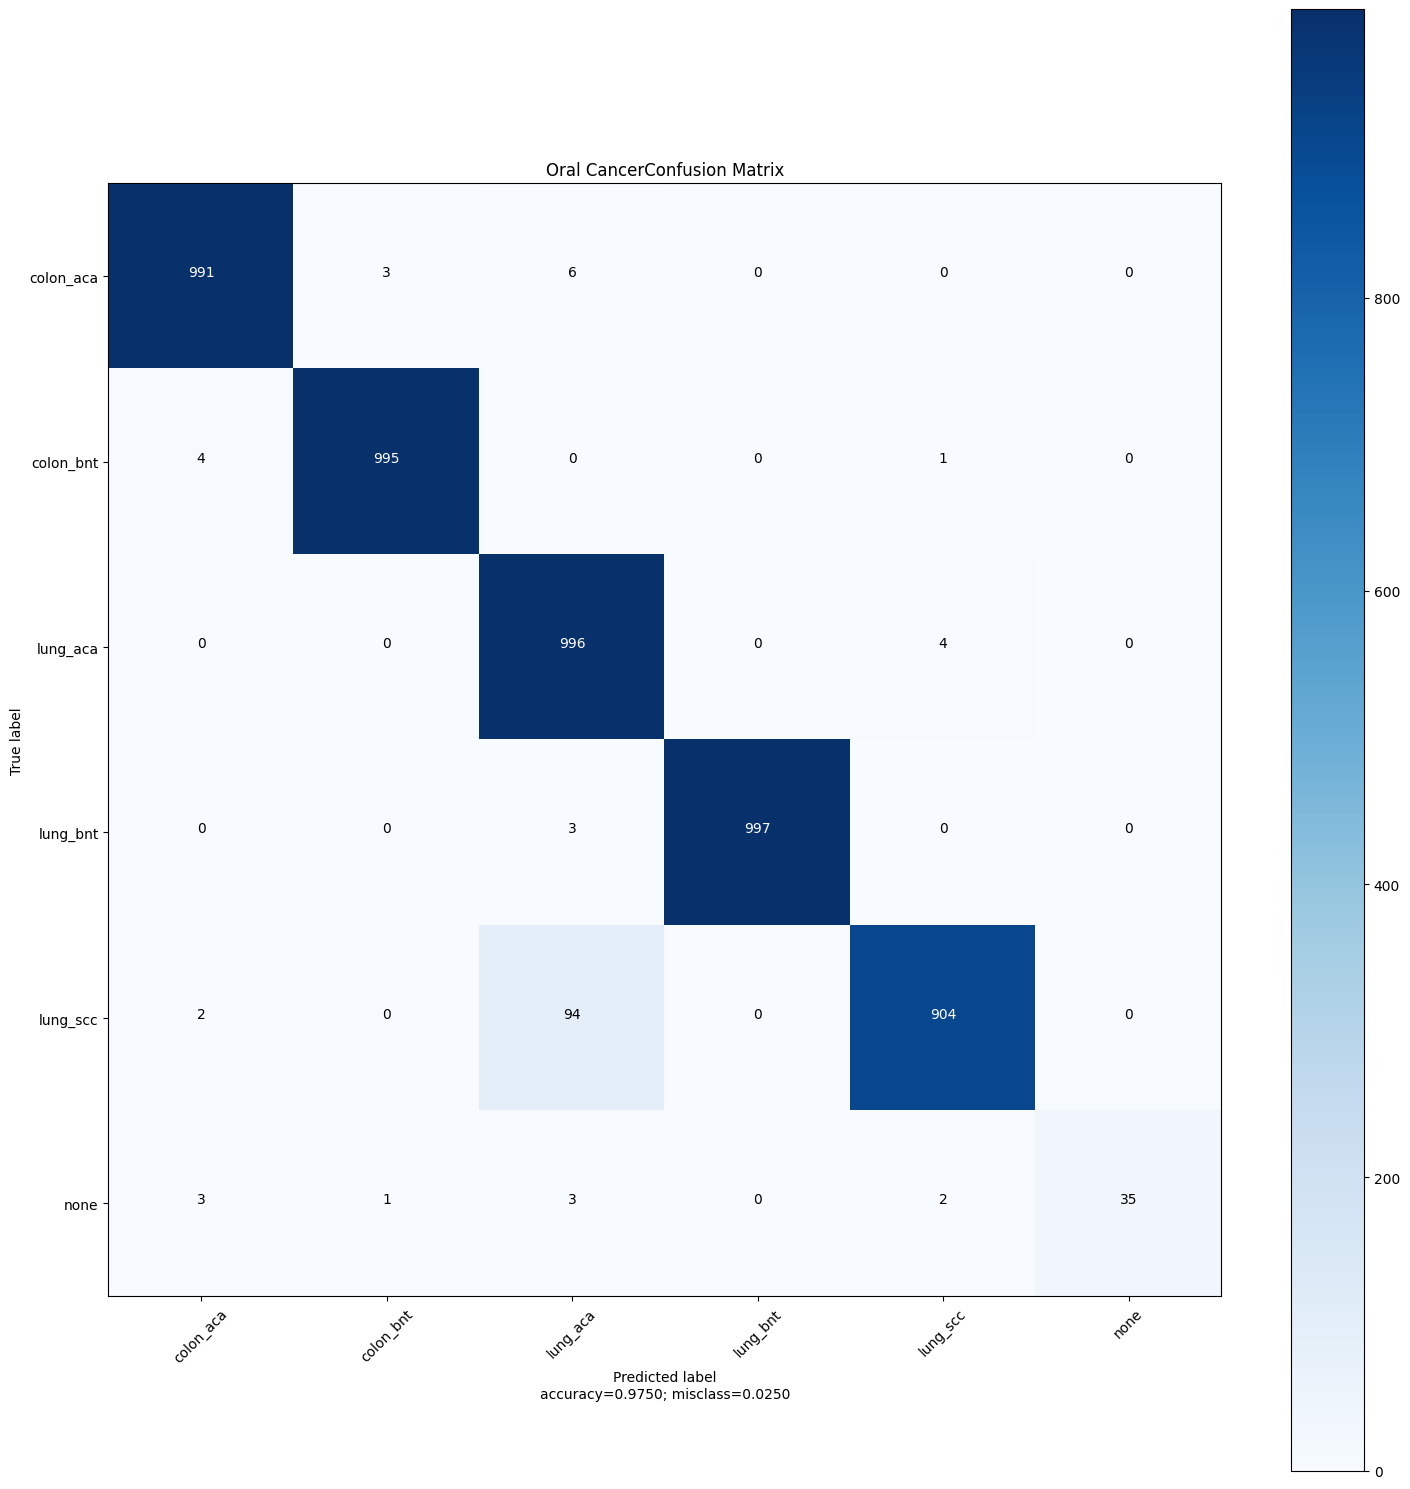

<Figure size 640x480 with 0 Axes>

In [16]:
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15240 files belonging to 4 classes.

For Training :  Found 12193 images belonging to 4 classes.

For Val :  Found 3047 images belonging to 4 classes.

No of Classes :  4
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl', 'none']
Image Shape :  (32, 256, 256, 3)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_4[0][0]']         
             

c:\Users\shiva\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


382/382 [==============================] - 553s 1s/step - loss: 1.3919 - accuracy: 0.6942 - val_loss: 1.8634 - val_accuracy: 0.7223 - lr: 0.0010
Epoch 2/20
382/382 [==============================] - ETA: 0s - loss: 0.4815 - accuracy: 0.8745
Epoch 2: val_loss improved from 1.86338 to 0.69743, saving model to Oral CancerMobileNet.h5
382/382 [==============================] - 215s 561ms/step - loss: 0.4815 - accuracy: 0.8745 - val_loss: 0.6974 - val_accuracy: 0.8356 - lr: 0.0010
Epoch 3/20
382/382 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.9230
Epoch 3: val_loss did not improve from 0.69743
382/382 [==============================] - 184s 482ms/step - loss: 0.2850 - accuracy: 0.9230 - val_loss: 0.7388 - val_accuracy: 0.8461 - lr: 0.0010
Epoch 4/20
382/382 [==============================] - ETA: 0s - loss: 0.1689 - accuracy: 0.9477
Epoch 4: val_loss did not improve from 0.69743
382/382 [==============================] - 169s 443ms/step - loss: 0.1689 - accuracy:

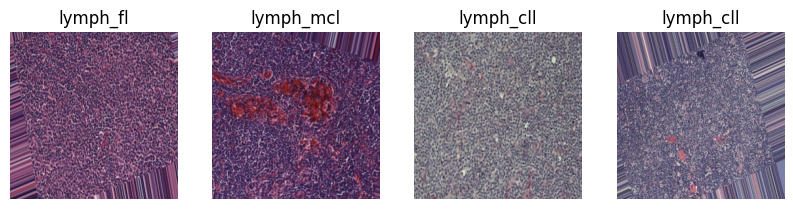

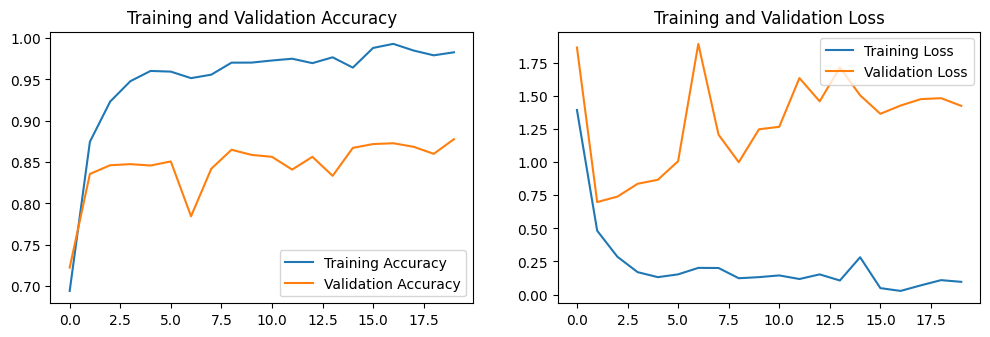

96/96 [==============================] - 27s 284ms/step - loss: 1.4234 - accuracy: 0.8776
Accuracy on the Test Set = 87.76 %
Model Saved!
True :  [0 0 0 ... 3 3 3]
96/96 [==============================] - 31s 309ms/step
Predicted :  [0 0 1 ... 3 3 3]


<Figure size 640x480 with 0 Axes>

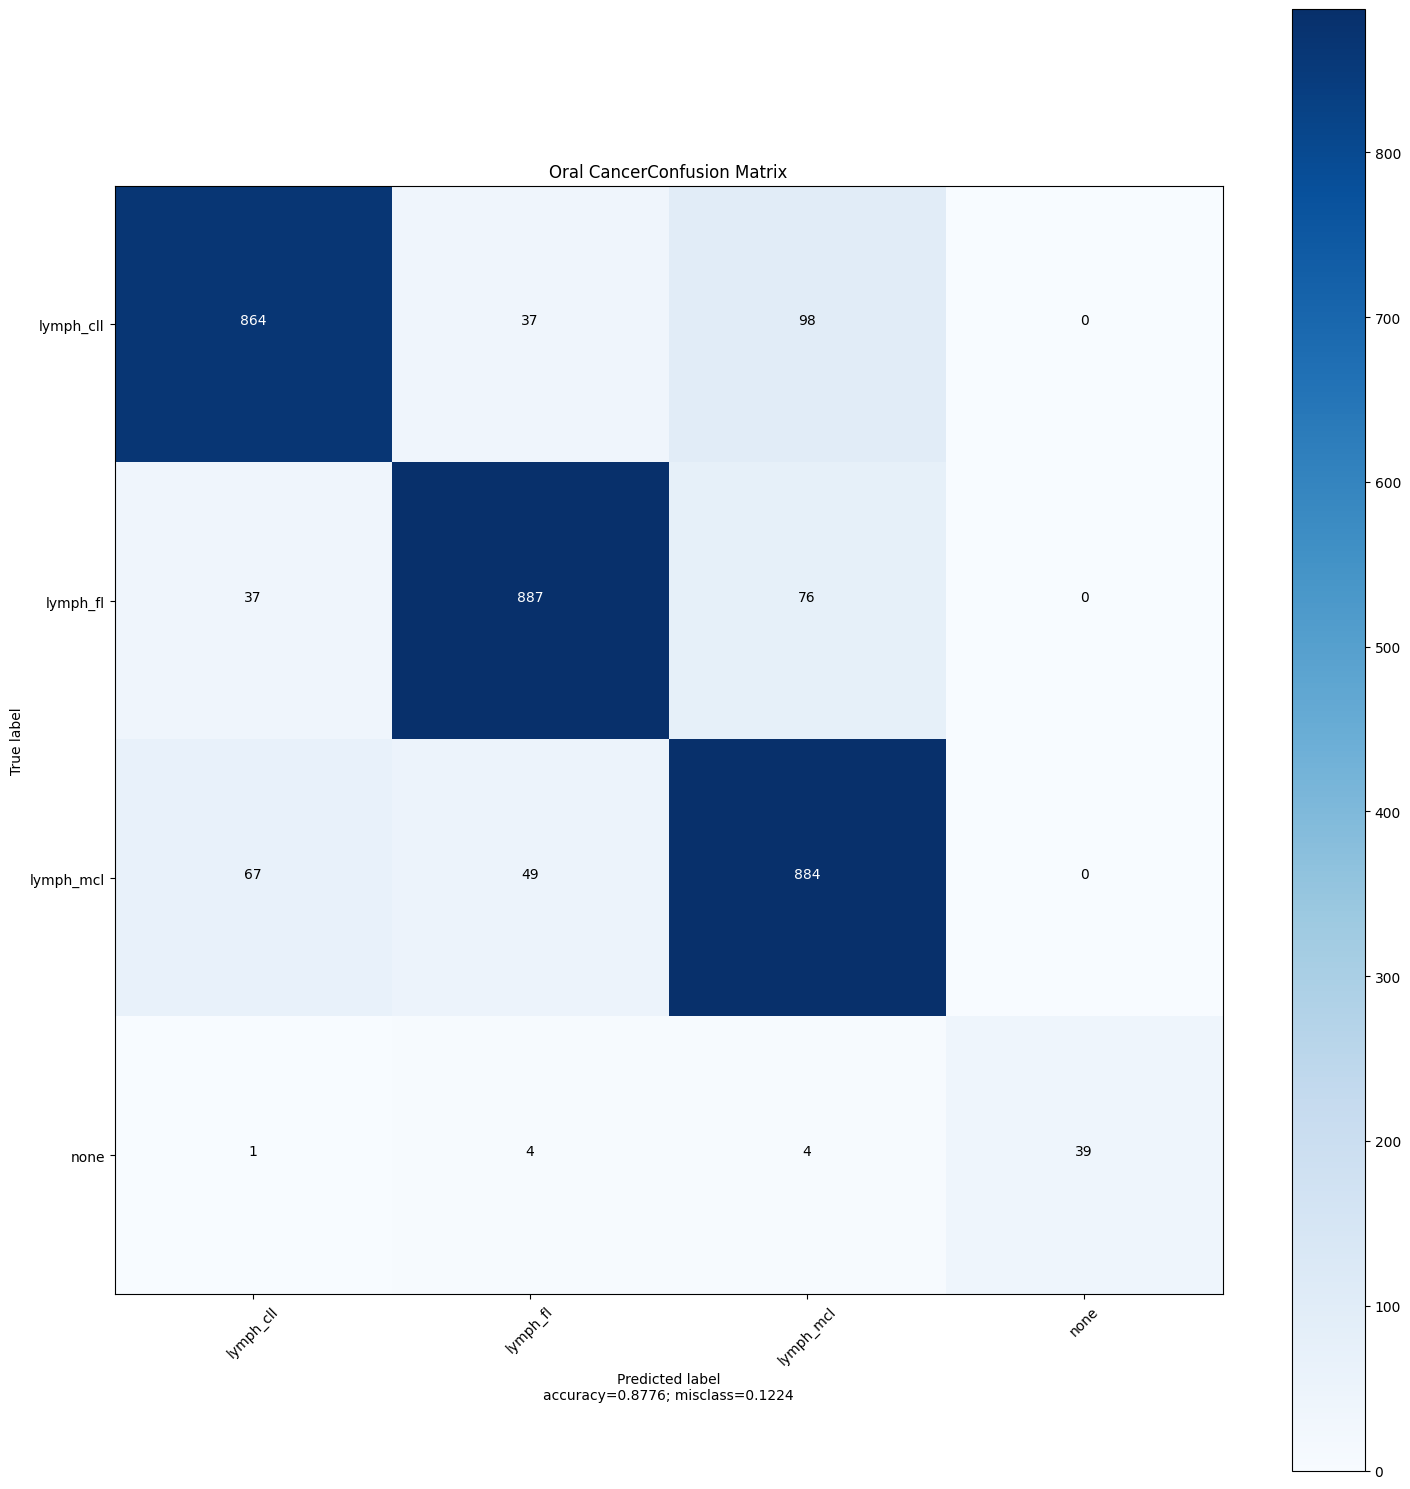

<Figure size 640x480 with 0 Axes>

In [17]:
cpath = os.path.join(mpath, 'Lymphoma')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10251 files belonging to 3 classes.

For Training :  Found 8201 images belonging to 3 classes.

For Val :  Found 2050 images belonging to 3 classes.

No of Classes :  3
Classes :  ['oral_normal', 'oral_scc', 'p_none']
Image Shape :  (32, 256, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_1[0][0]']         
                       

c:\Users\shiva\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


257/257 [==============================] - 143s 530ms/step - loss: 1.4161 - accuracy: 0.7610 - val_loss: 1.4941 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 2/20
257/257 [==============================] - ETA: 0s - loss: 0.5075 - accuracy: 0.8967
Epoch 2: val_loss did not improve from 1.49414
257/257 [==============================] - 99s 384ms/step - loss: 0.5075 - accuracy: 0.8967 - val_loss: 1.8705 - val_accuracy: 0.7927 - lr: 0.0010
Epoch 3/20
257/257 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.9320
Epoch 3: val_loss improved from 1.49414 to 1.18231, saving model to Oral CancerMobileNet.h5
257/257 [==============================] - 98s 382ms/step - loss: 0.3138 - accuracy: 0.9320 - val_loss: 1.1823 - val_accuracy: 0.8380 - lr: 0.0010
Epoch 4/20
257/257 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.9521
Epoch 4: val_loss did not improve from 1.18231
257/257 [==============================] - 95s 367ms/step - loss: 0.2223 - accuracy:

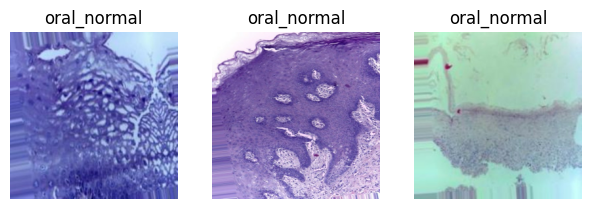

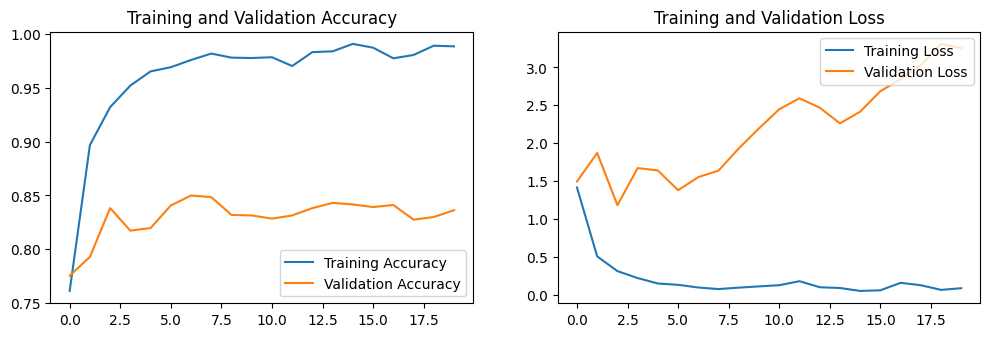

65/65 [==============================] - 22s 333ms/step - loss: 3.2516 - accuracy: 0.8361
Accuracy on the Test Set = 83.61 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
65/65 [==============================] - 21s 309ms/step
Predicted :  [0 0 1 ... 1 2 1]


<Figure size 640x480 with 0 Axes>

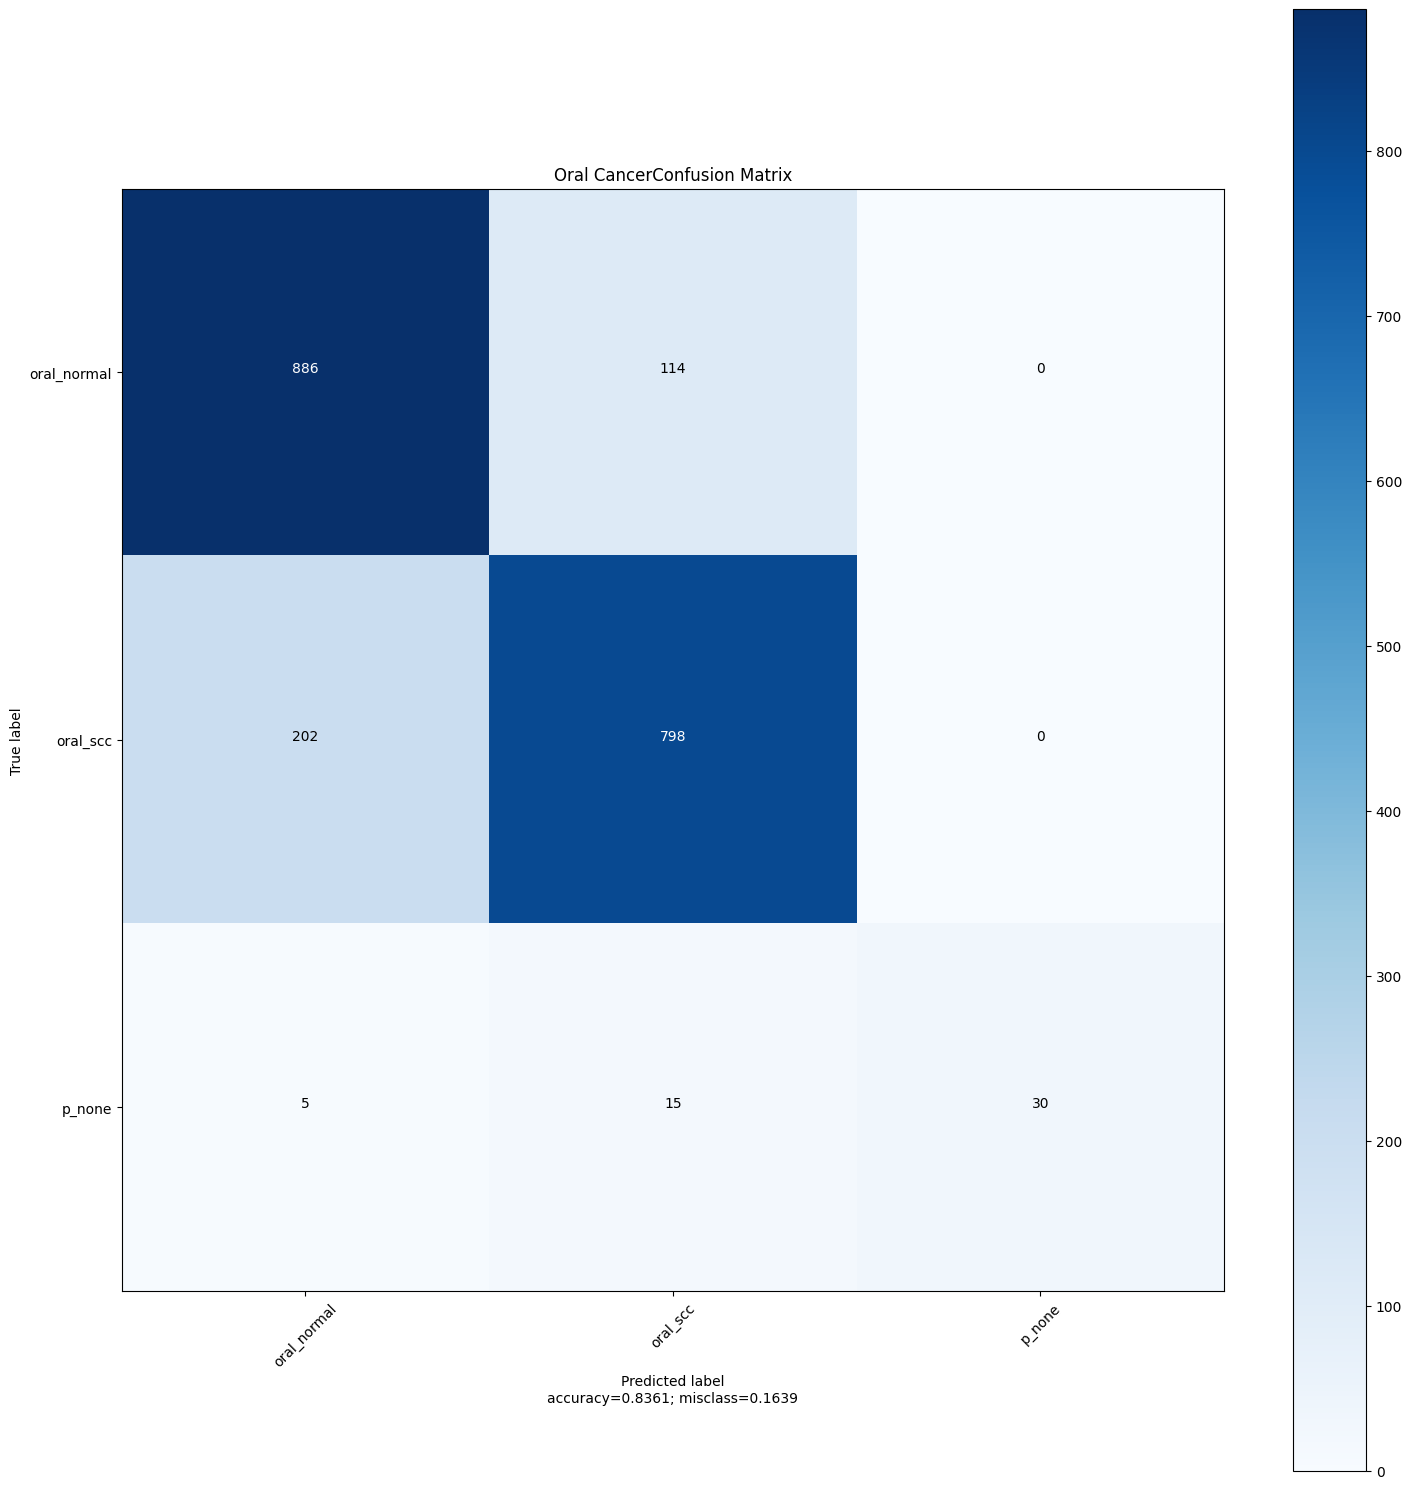

<Figure size 640x480 with 0 Axes>

In [13]:
cpath = os.path.join(mpath, 'Oral Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)